# Logistic regression - Risk prediction for Diabetes

## Purpose
* Identify lifestyle factors statistically associated with diabetes (or pre-diabetes) in a US sample using downsampled BRFSS data

## Method
### Assumption
* The outcome is binary *i.e.* 1 vs 0
* The observations are independent of each other
* There is a linear relationship between the logit of the probability of outcome and each predictor variables, where $\mathrm{logit}(p)=\log(\frac{p}{1-p})$
* There is no influential values (extreme values or outliers) in the continuous predictors
* There is no multi-collinearity among the predictors
* The sample size should be large enough. The general rule of thumb is at least 10 cases of the least frequent outcome for each independent variable
### Model
$$\begin{align*} \text{logit}(\pi_i) &= \mathbf{x}'_i\boldsymbol{\beta} = \beta_{0} + \beta_{1} x_{i1} + \ldots + \beta_{p} x_{ip} \\ \pi_i &= \frac{\exp(\mathbf{x}'_i\boldsymbol{\beta})}{1 + \exp(\mathbf{x}'_i\boldsymbol{\beta})} \end{align*}$$
* $i$: the index of the observation
* $p$: the number of predictors
* $\beta_{0}$ is the intercept
* $\beta_1, \beta_2, \ldots, \beta_p$ are the coefficients for the predictors
* $x_{i1}, x_{i2}, \ldots, x_{ip}$ are the feature values for observation $i$
* $\pi_i$ is the probability of the event (e.g., success or $Y = 1$) for observation $i$


## Data
The dataset is downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators) . It consists of the following columns:
1. `Diabetes_binary`: *(Binary)* 0 = no diabetes; 1 = pre-diabetes or diabetes 
2. `HighBP`: *(Binary)* 0 = no high BP; 1 = high BP 
3. `HighChol`: *(Binary)* 0 = no high cholesterol; 1 = high cholesterol 
4. `CholCheck`: *(Binary)* 0 = no cholesterol check in 5 years; 1 = yes cholesterol check in 5 years 
5. `BMI`: *(Integer)* Body Mass Index 
6. `Smoker`: *(Binary)* Have you smoked at least 100 cigarettes in your entire life? \[Note: 5 packs = 100 cigarettes\] 0 = no; 1 = yes 
7. `Stroke`: *(Binary)* (Ever told) you had a stroke. 0 = no; 1 = yes 
8. `HeartDiseaseorAttack`: *(Binary)* coronary heart disease (CHD) or myocardial infarction (MI) 0 = no; 1 = yes 
9. `PhysActivity`: *(Binary)* physical activity in past 30 days - not including job 0 = no; 1 = yes 
10. `Fruits`: *(Binary)* Consume Fruit 1 or more times per day 0 = no; 1 = yes 
11. `Veggies`: *(Binary)* Consume Vegetables 1 or more times per day 0 = no; 1 = yes 
12. `HvyAlcoholConsump`: *(Binary)* Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no; 1 = yes 
13. `AnyHealthcare`: *(Binary)* Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no; 1 = yes 
14. `NoDocbcCost`: *(Binary)* Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no; 1 = yes 
15. `GenHlth`: *(Integer)* Would you say that in general your health is (scale 1-5): 1 = excellent; 2 = very good; 3 = good; 4 = fair; 5 = poor 
16. `MentHlth`: *(Integer)* Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days 
17. `PhysHlth`: *(Integer)* Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days 
18. `DiffWalk`: *(Binary)* Do you have serious difficulty walking or climbing stairs? 0 = no; 1 = yes 
19. `Sex`: *(Binary)* Sex 0 = female; 1 = male 
20. `Age`: *(Integer)* Age. 13-level age category (AGEG5YR see codebook) 1 = 18-24; 2 = 25-29; ...; 13 = 80 or older 
21. `Education`: *(Integer)* Education Level. Education level (EDUCA see codebook) (scale 1-6) 1 = Never attended school or only kindergarten; 2 = Grades 1 through 8 (Elementary); 3 = Grades 9 through 11 (Some high school); 4 = Grade 12 or GED (High school graduate); 5 = College 1 year to 3 years (Some college or technical school); 6 = College 4 years or more (College graduate) 
22. `Income`: *(Integer)* Income. Income scale (INCOME2 see codebook) (scale 1-8) 1 = less than \\$10,000; 2 = \\$10,000 to less than \\$15,000;...; 8 = \\$75,000 or more

The schema can be download from [Centers for Disease Control and Prevention (CDC)](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf)

## Analysis

In [2]:
library(glm2)
library(ggplot2)
library(forcats)
library(dplyr)
library(purrr)
library(tidyr)
library(caret)
library(lmtest)
library(pROC)
library(MASS)
library(descr)
library(ResourceSelection)
library(pROC)
library(gridExtra)
library(cowplot)

In [3]:
chi_square_test <- function(df, x, y) {
  vector1 <- df[[x]]
  vector2 <- df[[y]]
  return(chisq.test(vector1, vector2,
                    correct = FALSE)$p.value)
}
t_test <- function(df, x, group) {
  t_test_result <- t.test(df[[x]] ~ df[[group]])
  print(t_test_result)
}
quite_chisquare <- quietly(chi_square_test)
quite_t <- quietly(t_test)

In [4]:
df0 <- read.csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

### Data checking

#### Dimension

In [5]:
print(paste("Number of rows:", nrow(df0)))
print(paste("Number of columns:", ncol(df0)))

[1] "Number of rows: 70692"
[1] "Number of columns: 22"


#### Data type

In [6]:
columns_to_factor <- c("Diabetes_binary", "HighBP", "HighChol",
                       "CholCheck", "Smoker", "Stroke",
                       "HeartDiseaseorAttack", "PhysActivity",
                       "Fruits", "Veggies", "HvyAlcoholConsump",
                       "AnyHealthcare", "NoDocbcCost", "GenHlth",
                       "DiffWalk", "Sex", "Age", "Education",
                       "Income")
genhlth_mapping <- c("Excellent" = "1",
                      "Very Good" = "2",
                      "Good" = "3",
                      "Fair" = "4",
                      "Poor" = "5")
agegp_mapping <- c("18-24" = "1", "25-29" = "2", "30-34" = "3",
                   "35-39" = "4", "40-44" = "5", "45-49" = "6",
                   "50-54" = "7", "55-59" = "8", "60-64" = "9",
                   "65-69" = "10", "70-74" = "11", "75-79" = "12",
                   "80 or older" = "13")
edu_mapping <- c("Never attended school or only kindergarten" = "1",
                 "Elementary" = "2",
                 "Some high school" = "3",
                 "High school graduate" = "4",
                 "Some college or technical school" = "5",
                 "College graduate" = "6")
income_mapping <- c("Less than $10k" = "1",
                    "$10k to less than $15k" = "2",
                    "$15k to less than $20k" = "3",
                    "$20k to less than $25k" = "4",
                    "$25k to less than $35k" = "5",
                    "$35k to less than $50k" = "6",
                    "$50k to less than $75k" = "7",
                    "$75k or more" = "8")

In [7]:
df0 <- df0 %>%
  mutate(across(all_of(columns_to_factor), factor)) %>%
  mutate(GenHlth = fct_recode(GenHlth, !!!genhlth_mapping)) %>%
  mutate(Age = fct_recode(Age, !!!agegp_mapping)) %>%
  mutate(Education = fct_recode(Education, !!!edu_mapping)) %>%
  mutate(Income = fct_recode(Income, !!!income_mapping))
rm(genhlth_mapping, agegp_mapping,
   edu_mapping, income_mapping, columns_to_factor)

In [8]:
data.frame(Type = sapply(df0, class))

,Type
,<chr>
Diabetes_binary,factor
HighBP,factor
HighChol,factor
CholCheck,factor
BMI,numeric
Smoker,factor
Stroke,factor
HeartDiseaseorAttack,factor
PhysActivity,factor


#### Missing value

In [9]:
print(colSums(is.na(df0)))

     Diabetes_binary               HighBP             HighChol 
                   0                    0                    0 
           CholCheck                  BMI               Smoker 
                   0                    0                    0 
              Stroke HeartDiseaseorAttack         PhysActivity 
                   0                    0                    0 
              Fruits              Veggies    HvyAlcoholConsump 
                   0                    0                    0 
       AnyHealthcare          NoDocbcCost              GenHlth 
                   0                    0                    0 
            MentHlth             PhysHlth             DiffWalk 
                   0                    0                    0 
                 Sex                  Age            Education 
                   0                    0                    0 
              Income 
                   0 


* There is no missing value

### Data exploration

In [10]:
target <- "Diabetes_binary"
var_continuous <- names(df0)[sapply(df0, is.numeric)]
var_discrete <- setdiff(colnames(df0), c(var_continuous, target))

In [11]:
print(paste("Target:", target))
print(paste("Continuous features:", paste(var_continuous, collapse = ", ")))
print(paste("Categorical features:", paste(var_discrete, collapse = ", ")))

[1] "Target: Diabetes_binary"
[1] "Continuous features: BMI, MentHlth, PhysHlth"
[1] "Categorical features: HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, DiffWalk, Sex, Age, Education, Income"


#### Target

In [12]:
table(df0[[target]])


    0     1 
35346 35346 

#### Data visulisation: by target

In [13]:
plot_binary <- function(df, var_name, title, show_legend = TRUE) {
  df_percent <- df %>%
    group_by(!!sym(var_name), Diabetes_binary) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(!!sym(var_name)) %>%
    mutate(percentage = count / sum(count) * 100)
  p <- ggplot(df_percent) +
    aes(x = !!sym(var_name), y = percentage, fill = Diabetes_binary) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = var_name, y = "Percentage", fill = "Diabetes_binary") +
    scale_x_discrete(labels = c("0" = "No", "1" = "Yes")) +
    theme(axis.title = element_text(size = 16),
          axis.text = element_text(size = 14),
          legend.title = element_text(size = 14),
          legend.text = element_text(size = 12),
          plot.title = element_text(size = 18),
          legend.position = "right") +
    ggtitle(paste("% of diabetes by", title))
  return(p)
}

In [14]:
plot_ordinal <- function(df, var_name, title, reverse_levels = FALSE) {
  df_percent <- df %>%
    group_by(!!sym(var_name), Diabetes_binary) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(!!sym(var_name)) %>%
    mutate(percentage = (count / sum(count)) * 100)
  if (reverse_levels) {
    df_percent <- df_percent %>%
      mutate(!!sym(var_name) := factor(!!sym(var_name), levels = rev(levels(!!sym(var_name)))))
  }
  g <- ggplot(df_percent, aes(x = !!sym(var_name), y = percentage, fill = factor(Diabetes_binary))) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = var_name, y = "Percentage", fill = "Diabetes Outcome") +
    ggtitle(paste("% of Diabetes Outcome by", title)) +
    theme(
      axis.title = element_text(size = 16),
      axis.text = element_text(size = 14),
      legend.title = element_text(size = 14),
      legend.text = element_text(size = 12),
      plot.title = element_text(size = 18)
    )
  return(g)
}

In [15]:
plot_count <- function(df, var_name, bins, labels, health_type) {
  df_percent <- df %>%
    mutate(health_group = cut(!!sym(var_name), breaks = bins, labels = labels, right = TRUE)) %>%
    group_by(health_group, Diabetes_binary) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(health_group) %>%
    mutate(percentage = (count / sum(count)) * 100)
  ggplot(df_percent, aes(x = health_group, y = percentage, fill = factor(Diabetes_binary))) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "Number of days", y = "Percentage", fill = "Diabetes Outcome") +
    ggtitle(paste("% of Diabetes Outcome by Days of Poor", health_type)) +
    theme(
      axis.title = element_text(size = 16),
      axis.text = element_text(size = 14),
      legend.title = element_text(size = 14),
      legend.text = element_text(size = 12),
      plot.title = element_text(size = 18)
    )
}

In [16]:
arrange_plots <- function(list_plots, legend, nrow_plot, ncol_plot) {
    # Arrange plots in a grid
    plots_in_grid <- plot_grid(plotlist = list_plots, nrow = nrow_plot, ncol = ncol_plot)
    # Add the legend separately in 2 columns: plots and legend and adjust width ratio of plots and legend
    final_plot <- plot_grid(plots_in_grid, legend, ncol = 2, rel_widths = c(3, 0.5))
    return (final_plot)
}

##### Health
* There are 6 variables related to patients' health: `HighBP`*(binary)*, `HighChol`*(binary)*, `BMI`*(numerical)*, `Stroke`*(binary)*, `HeartDiseaseorAttack`*(binary)*, `DiffWalk`*(binary)*

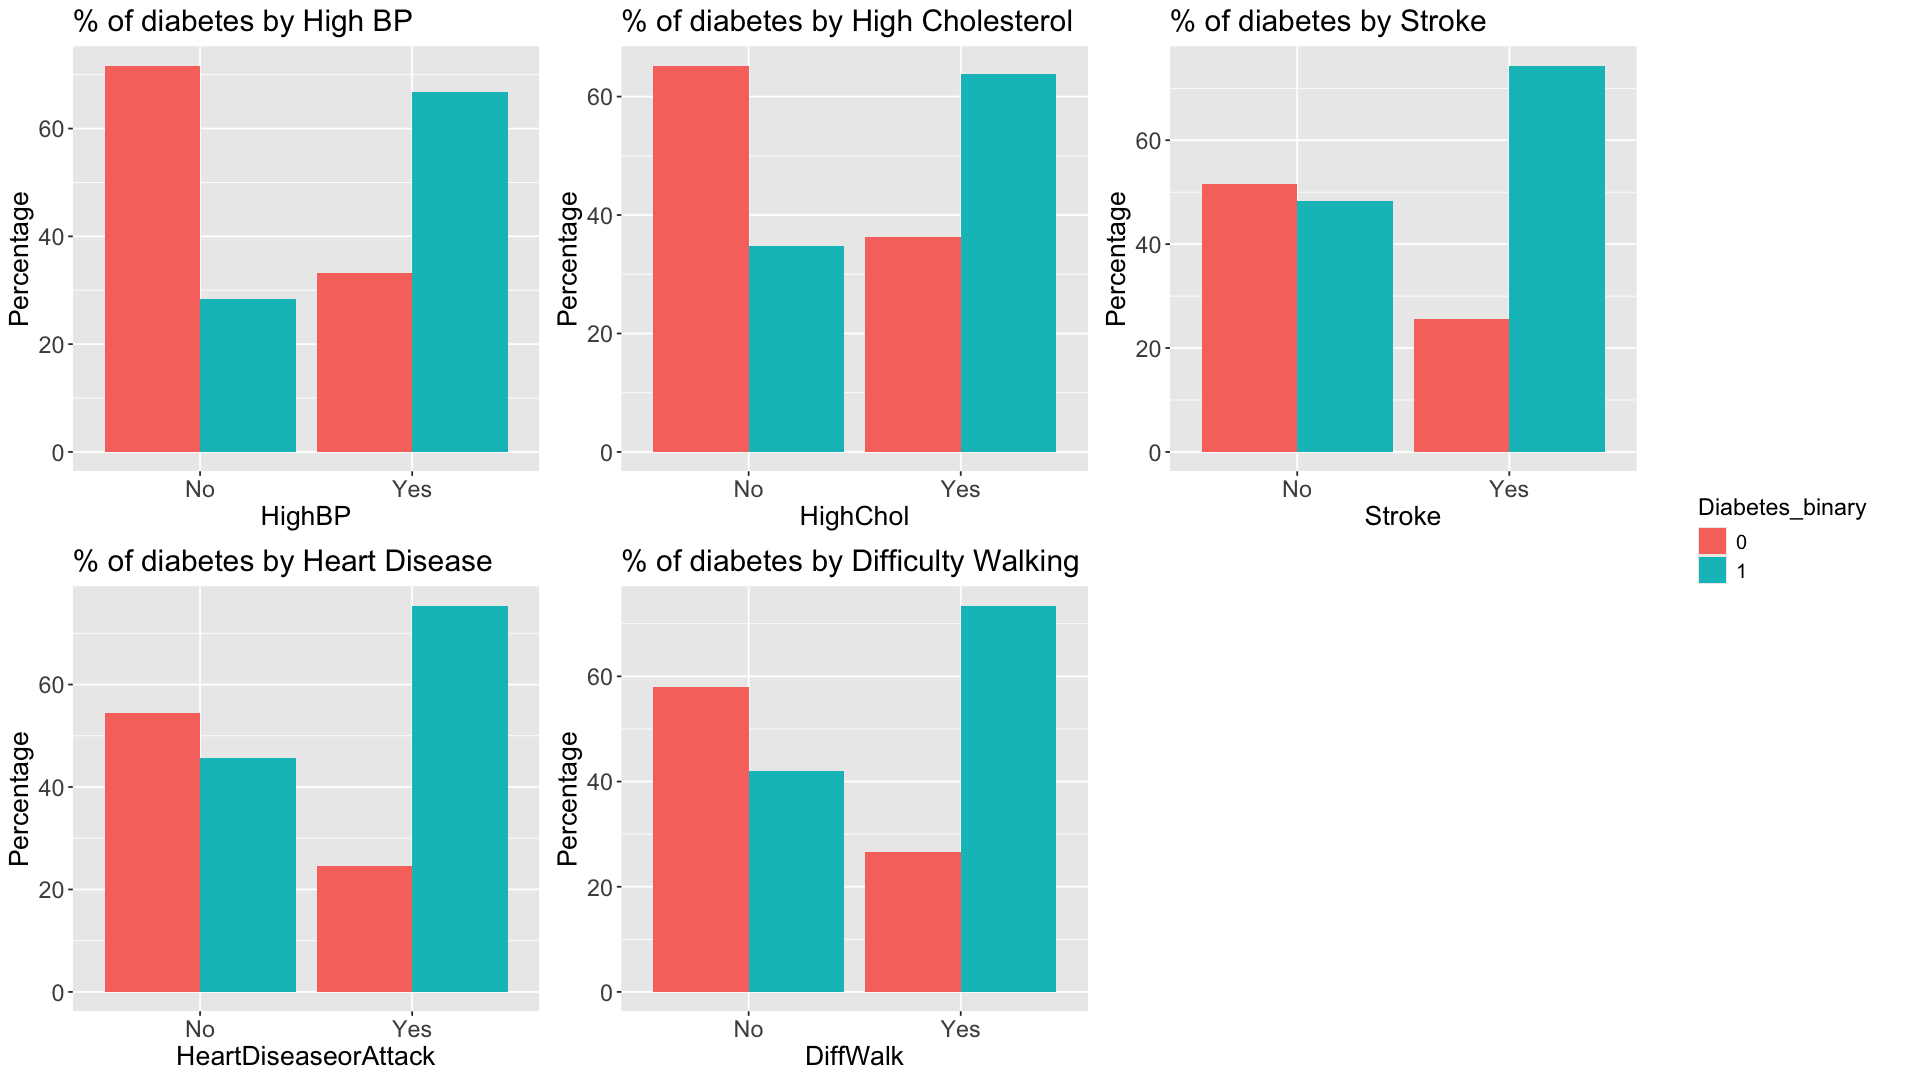

In [17]:
vars <- c("HighBP", "HighChol", "Stroke", "HeartDiseaseorAttack", "DiffWalk")
title <- c("High BP", "High Cholesterol", "Stroke", "Heart Disease", "Difficulty Walking")
# Generate plots for all variables, with the legend only in the first plot
plots <- lapply(seq_along(vars), function(i) {
  plot_binary(df0, vars[i], title[i], show_legend = (i == 1))
})
# Extract the legend from the first plot
legend <- get_plot_component(plots[[1]], 'guide-box-right', return_all = TRUE)
# Remove the legend from all plots to ensure consistent sizing
plots <- lapply(plots, function(p) p + theme(legend.position = "none"))
# Arrange plots in a 2x3 grid with the legend placed externally
options(repr.plot.width = 16, repr.plot.height = 9)
arrange_plots(plots,legend, 2, 3)
options(repr.plot.width = NULL, repr.plot.height = NULL)

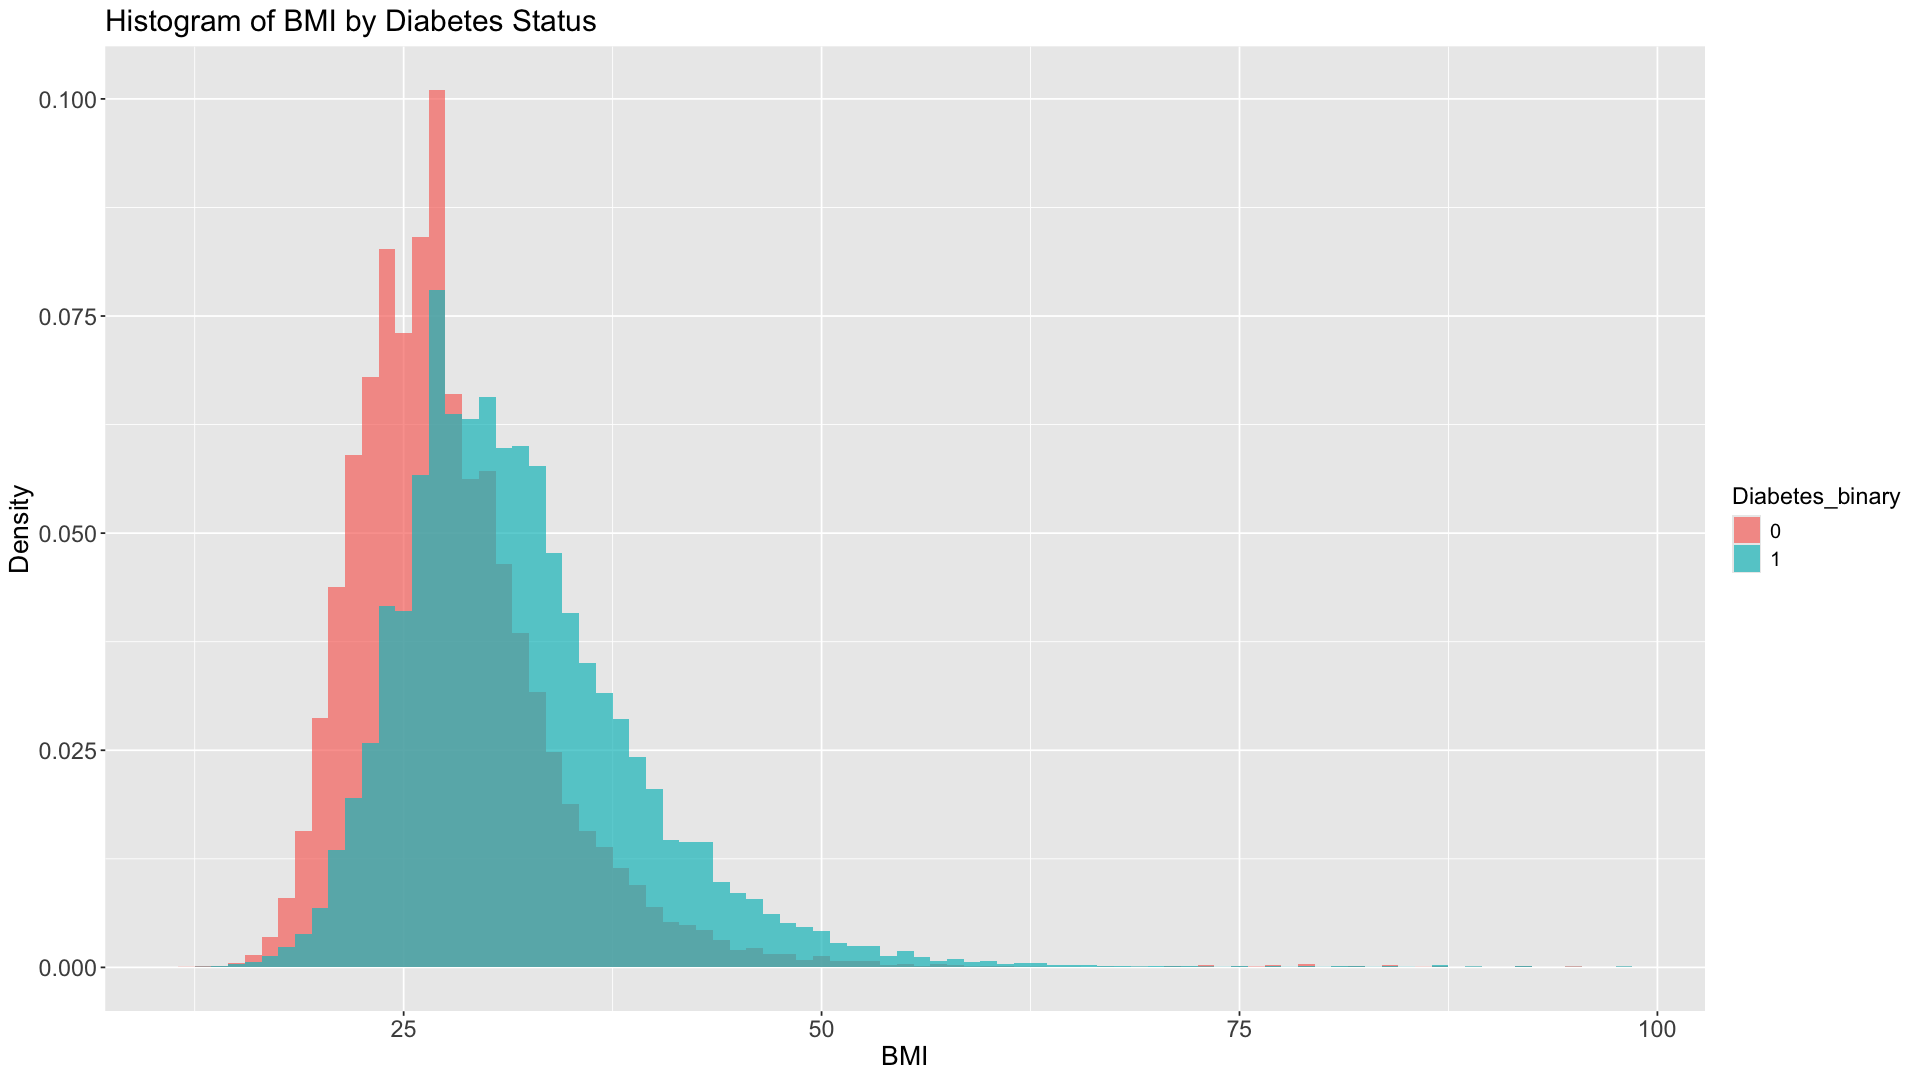

In [18]:
options(repr.plot.width = 16, repr.plot.height = 9)
ggplot(df0) +
  aes(x = BMI, y = after_stat(density), fill = Diabetes_binary) +    
  geom_histogram(position = "identity", alpha = 0.7, binwidth = 1) +
  labs(title = "Histogram of BMI by Diabetes Status",
       x = "BMI", y="Density") + 
  theme(axis.title = element_text(size = 16),
        axis.text = element_text(size = 14),
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        plot.title = element_text(size = 18))
options(repr.plot.width = NULL, repr.plot.height = NULL)

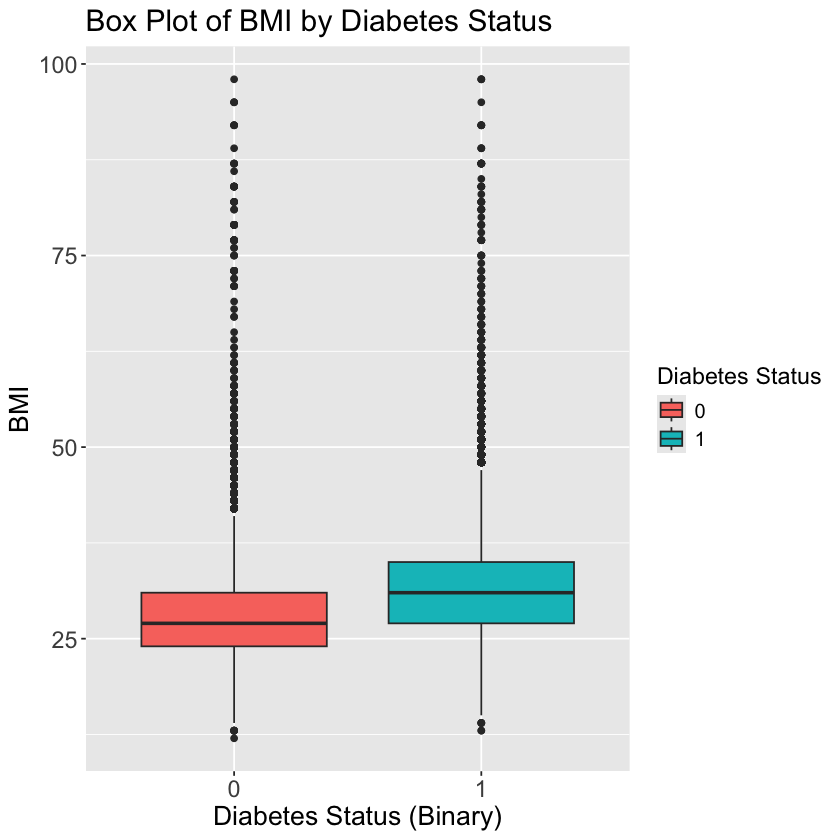

In [19]:
ggplot(df0, aes(x = Diabetes_binary, y = BMI, fill = Diabetes_binary)) +
  geom_boxplot() +
  labs(x = "Diabetes Status (Binary)", 
       y = "BMI", 
       title = "Box Plot of BMI by Diabetes Status", 
       fill = "Diabetes Status") + 
  theme(axis.title = element_text(size = 16),
        axis.text = element_text(size = 14),
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        plot.title = element_text(size = 18))

##### Perceived health
* There are 3 variables related to preceived health: `GenHlth`*(ordinal)*, `MentHlth`*(numerical)*, `PhysHlth`*(numerical)*
* It is common to perform logarithmic or square root transformation for count data 

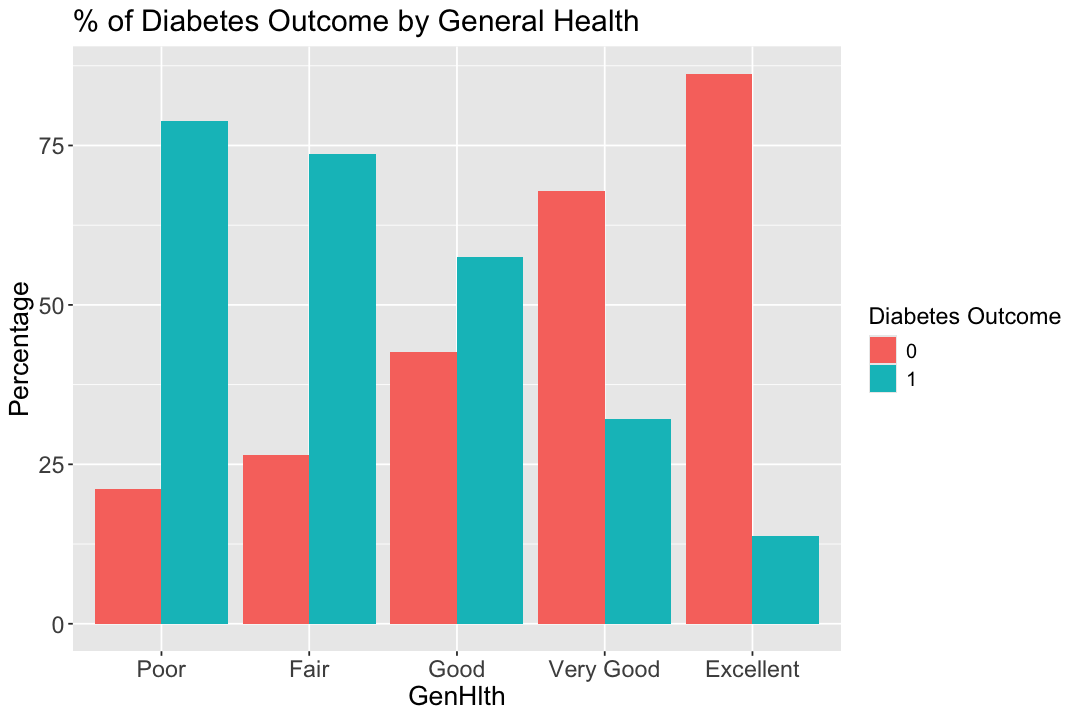

In [20]:
options(repr.plot.width = 9, repr.plot.height = 6)
print(plot_ordinal(df0, "GenHlth", "General Health", reverse_levels=TRUE))
options(repr.plot.width = NULL, repr.plot.height = NULL)

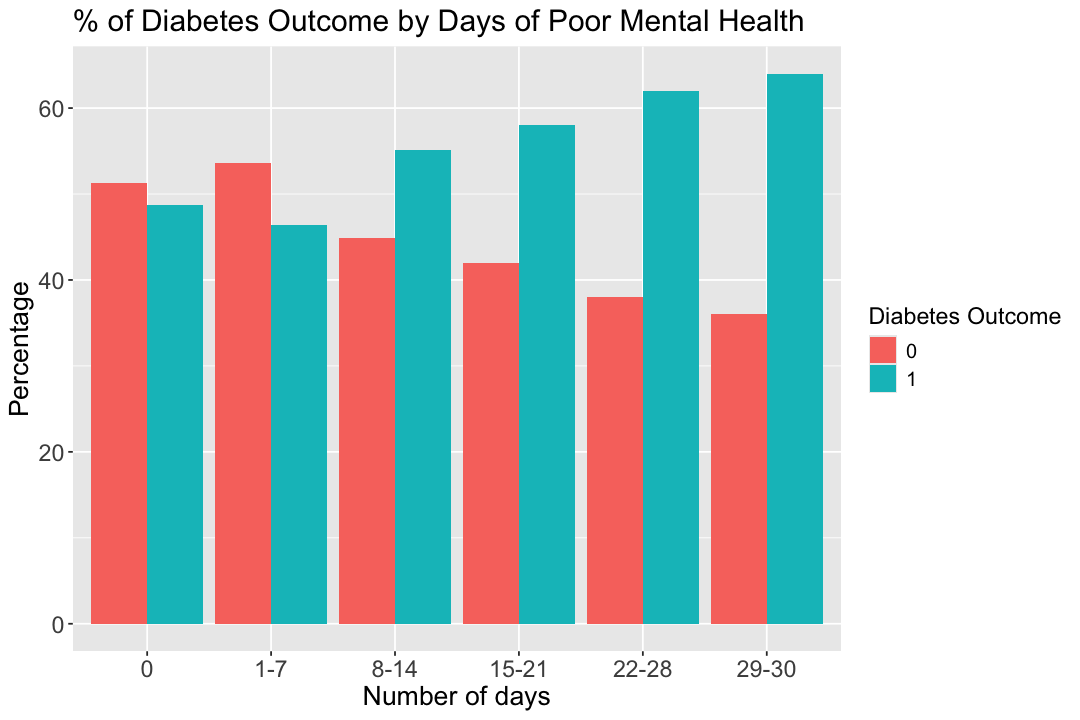

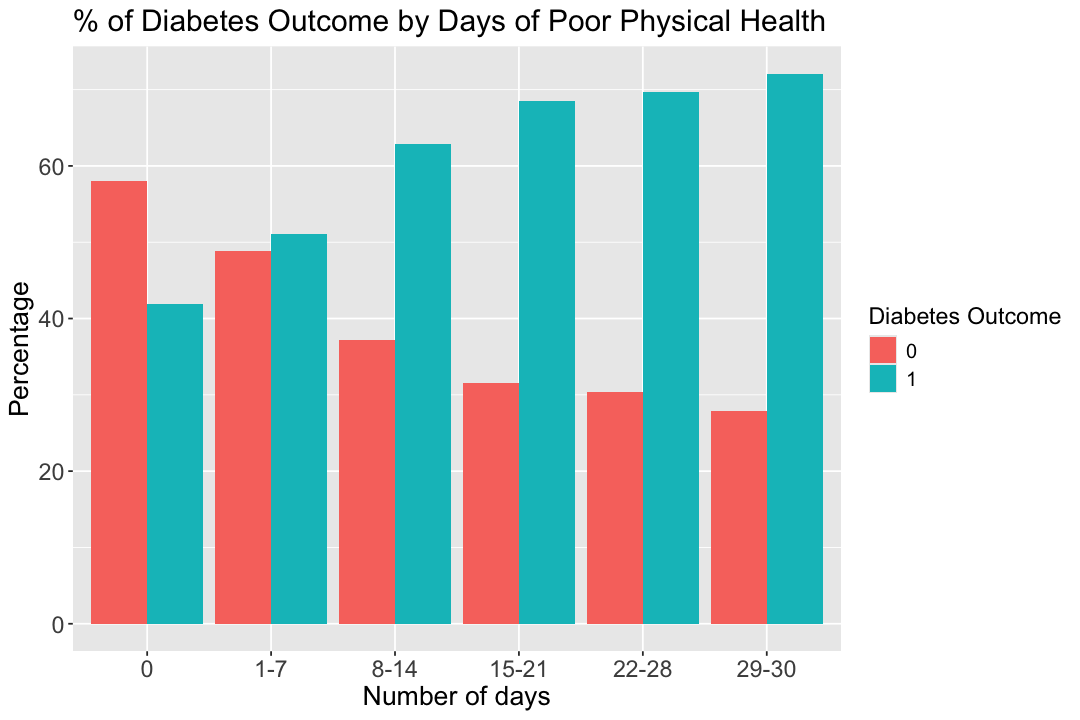

In [21]:
bins <- c(-1, 0, 7, 14, 21, 28, 30)
labels <- c('0', '1-7', '8-14', '15-21', '22-28', '29-30')
options(repr.plot.width = 9, repr.plot.height = 6)
plot_count(df0, "MentHlth", bins, labels, "Mental Health")
plot_count(df0, "PhysHlth", bins, labels, "Physical Health")
options(repr.plot.width = NULL, repr.plot.height = NULL)

##### Lifestyle
* There are 6 variables related to lifestyle: `CholCheck`_(binary)_, `Smoker`_(binary)_, `PhysActivity`_(binary)_, `Fruits`_(binary)_, `Veggies`_(binary)_, `HvyAlcoholConsump`_(binary)_

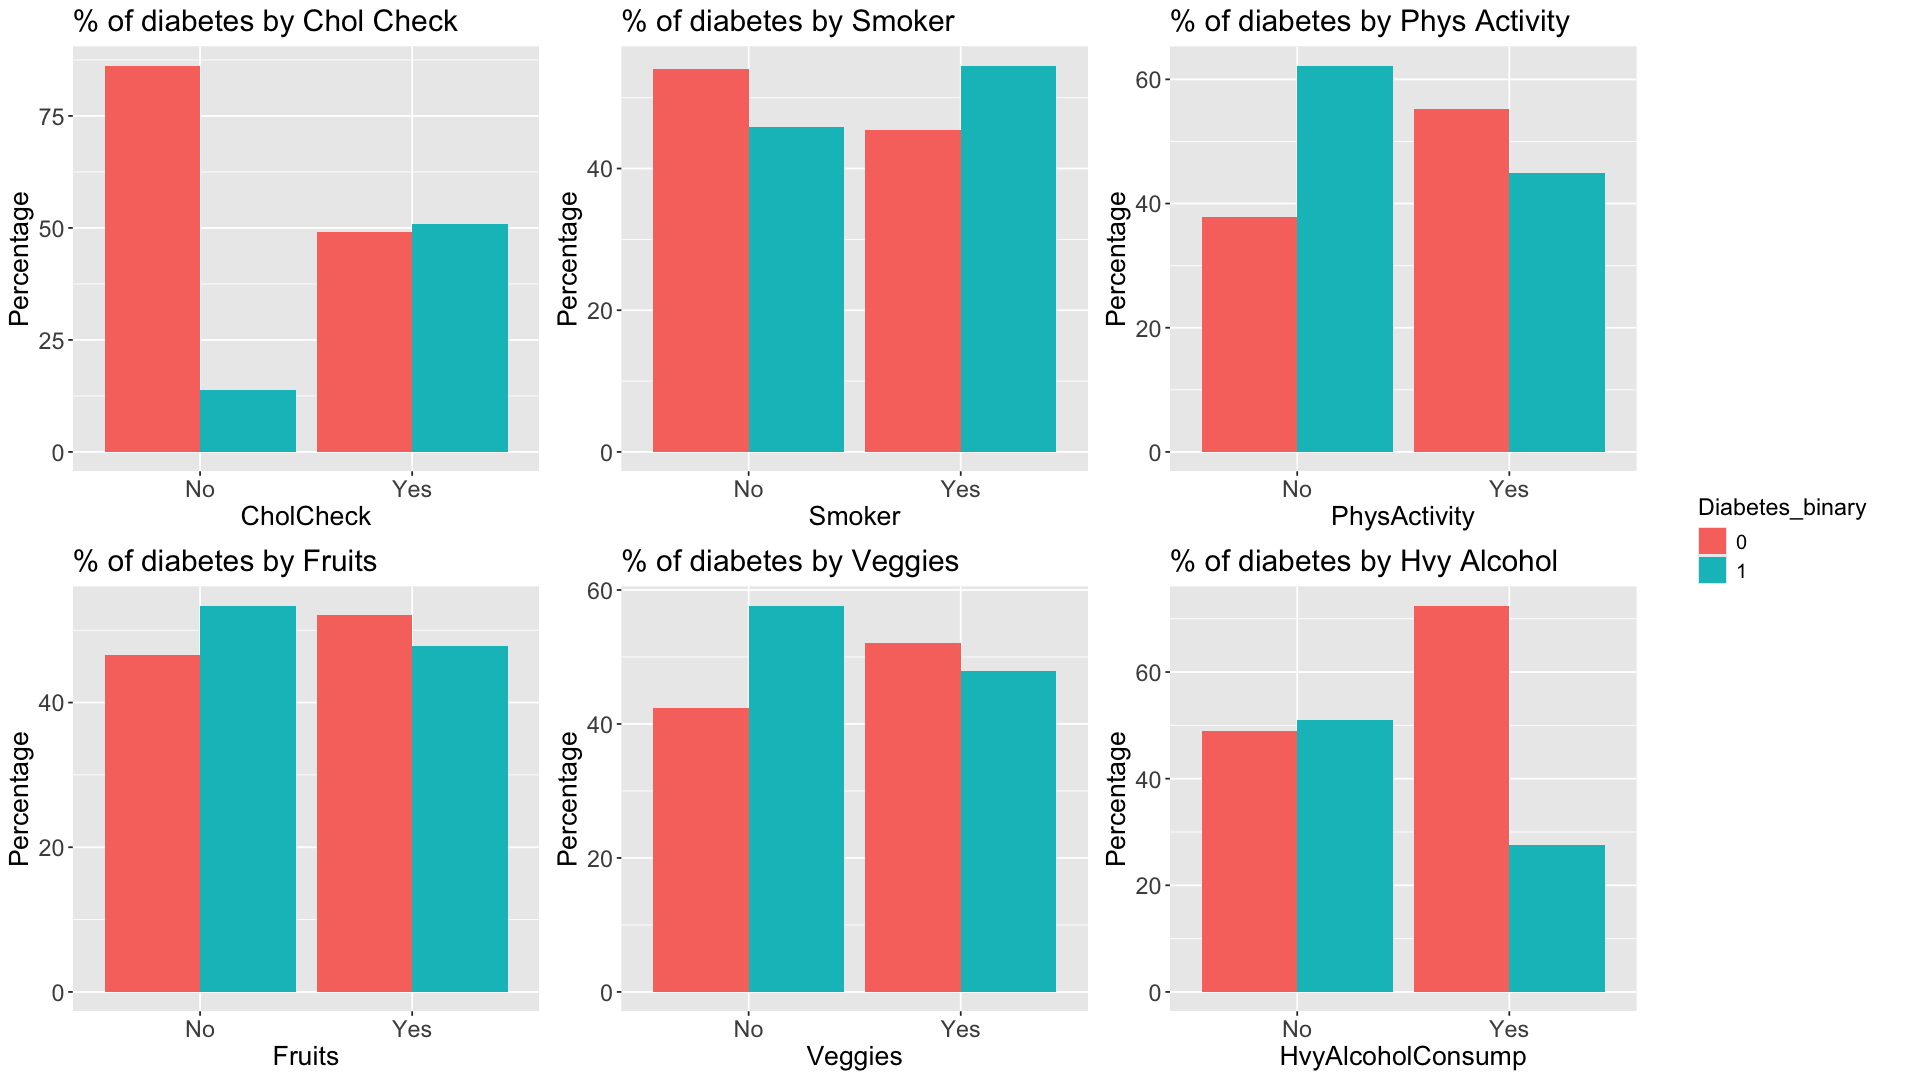

In [22]:
vars <- c("CholCheck", "Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump")
title <- c("Chol Check", "Smoker", "Phys Activity", "Fruits", "Veggies", "Hvy Alcohol")
plots <- lapply(seq_along(vars), function(i) {
  plot_binary(df0, vars[i], title[i], show_legend = (i == 1))
})
legend <- get_plot_component(plots[[1]], 'guide-box-right', return_all = TRUE)
plots <- lapply(plots, function(p) p + theme(legend.position = "none"))
options(repr.plot.width = 16, repr.plot.height = 9)
arrange_plots(plots,legend, 2, 3)
options(repr.plot.width = NULL, repr.plot.height = NULL)

##### Financial difficulty
* There are 2 variables related to financial difficulty: `AnyHealthcare`_(binary)_ and `NoDocbcCost`_(binary)_

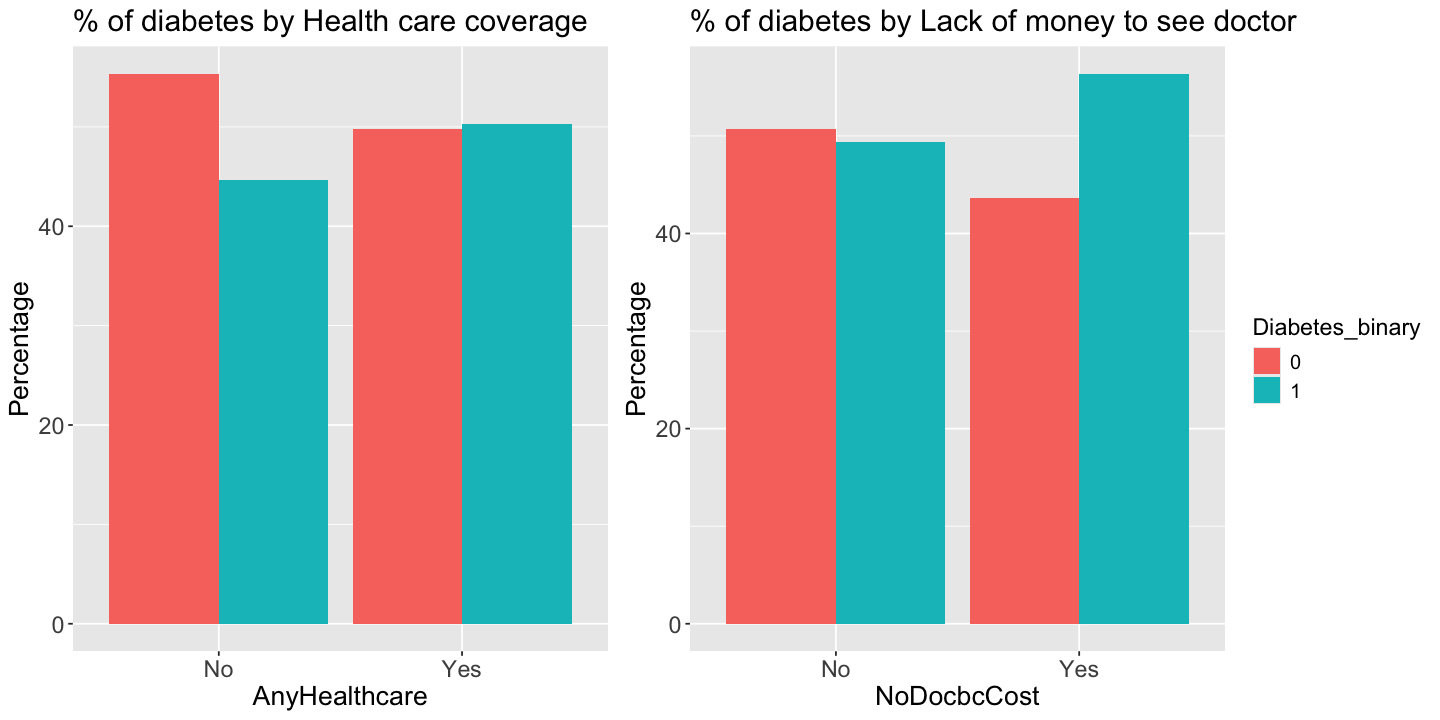

In [23]:
vars <- c("AnyHealthcare", "NoDocbcCost")
title <- c("Health care coverage", "Lack of money to see doctor")
plots <- lapply(seq_along(vars), function(i) {
  plot_binary(df0, vars[i], title[i], show_legend = (i == 1))
})
legend <- get_plot_component(plots[[1]], 'guide-box-right', return_all = TRUE)
plots <- lapply(plots, function(p) p + theme(legend.position = "none"))
options(repr.plot.width = 12, repr.plot.height = 6)
arrange_plots(plots,legend, 1, 2)
options(repr.plot.width = NULL, repr.plot.height = NULL)

##### Demographic
* There are 4 demographic variables: `Sex`_(binary)_, `Age`_(ordinal)_, `Education`_(ordinal)_, `Income`_(ordinal)_

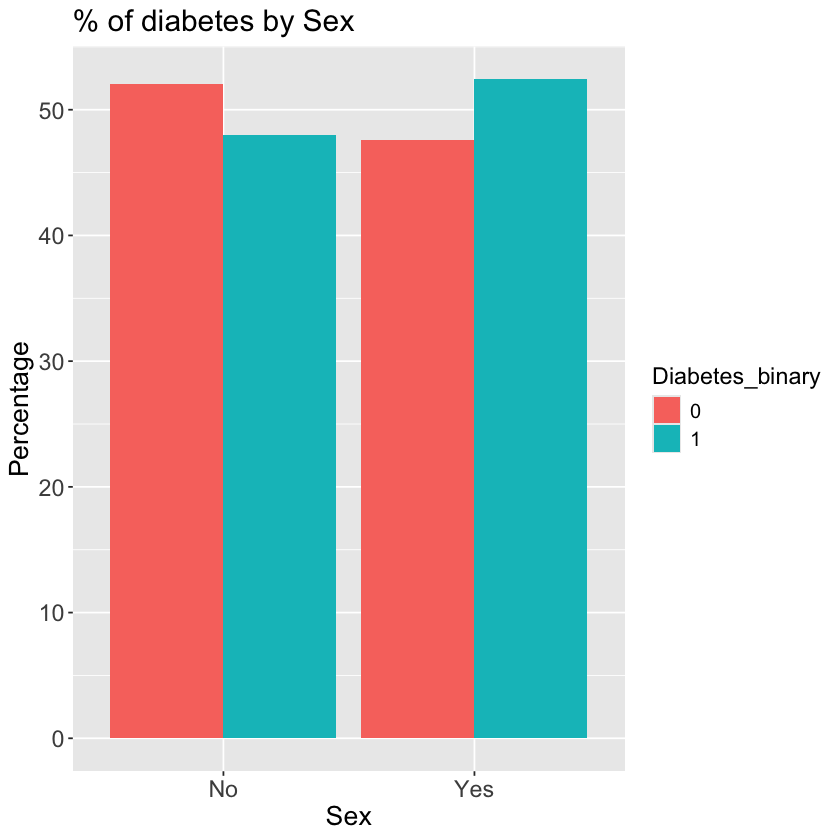

In [24]:
plot <- plot_binary(df0, "Sex", "Sex", show_legend = TRUE)
print(plot)

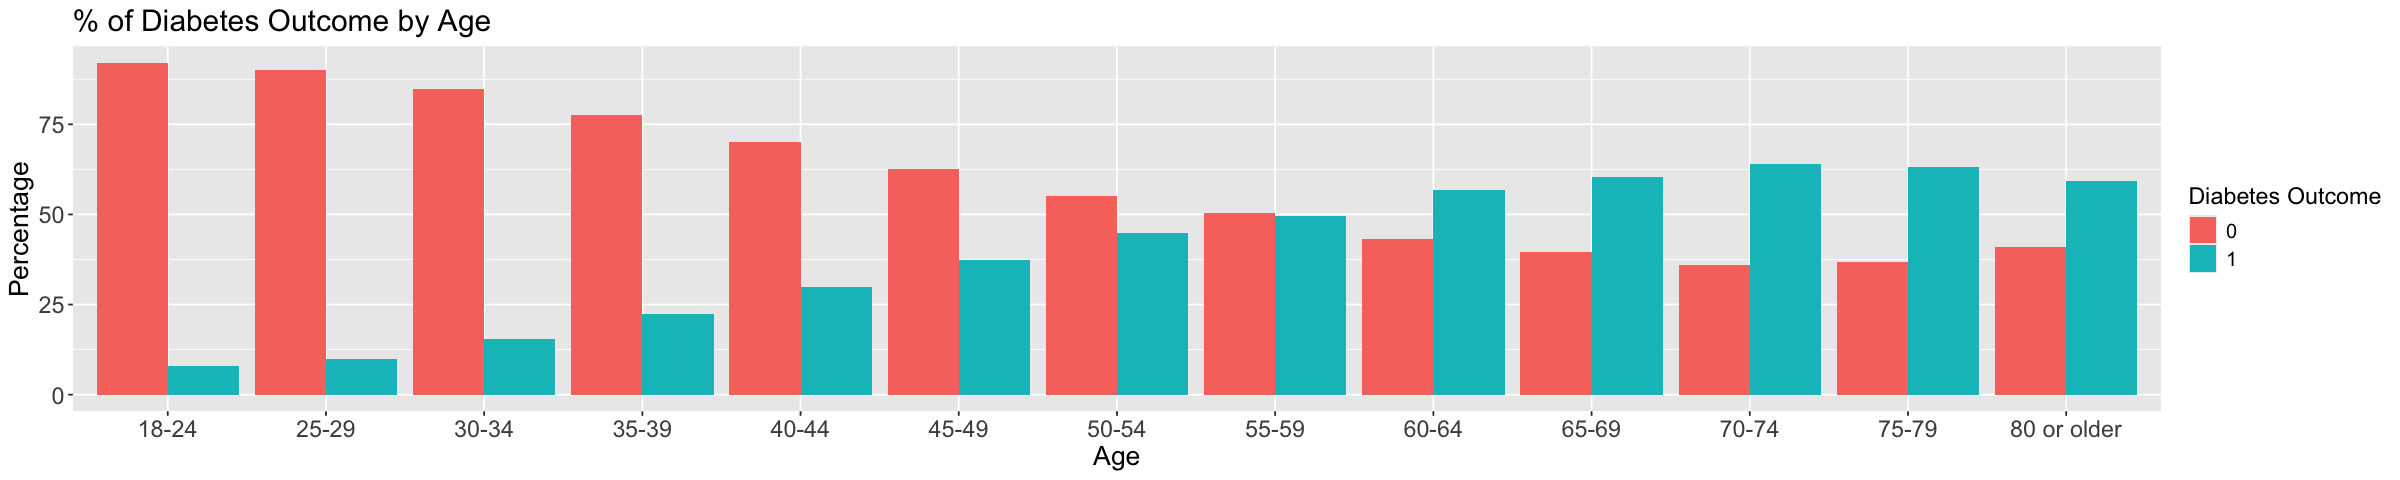

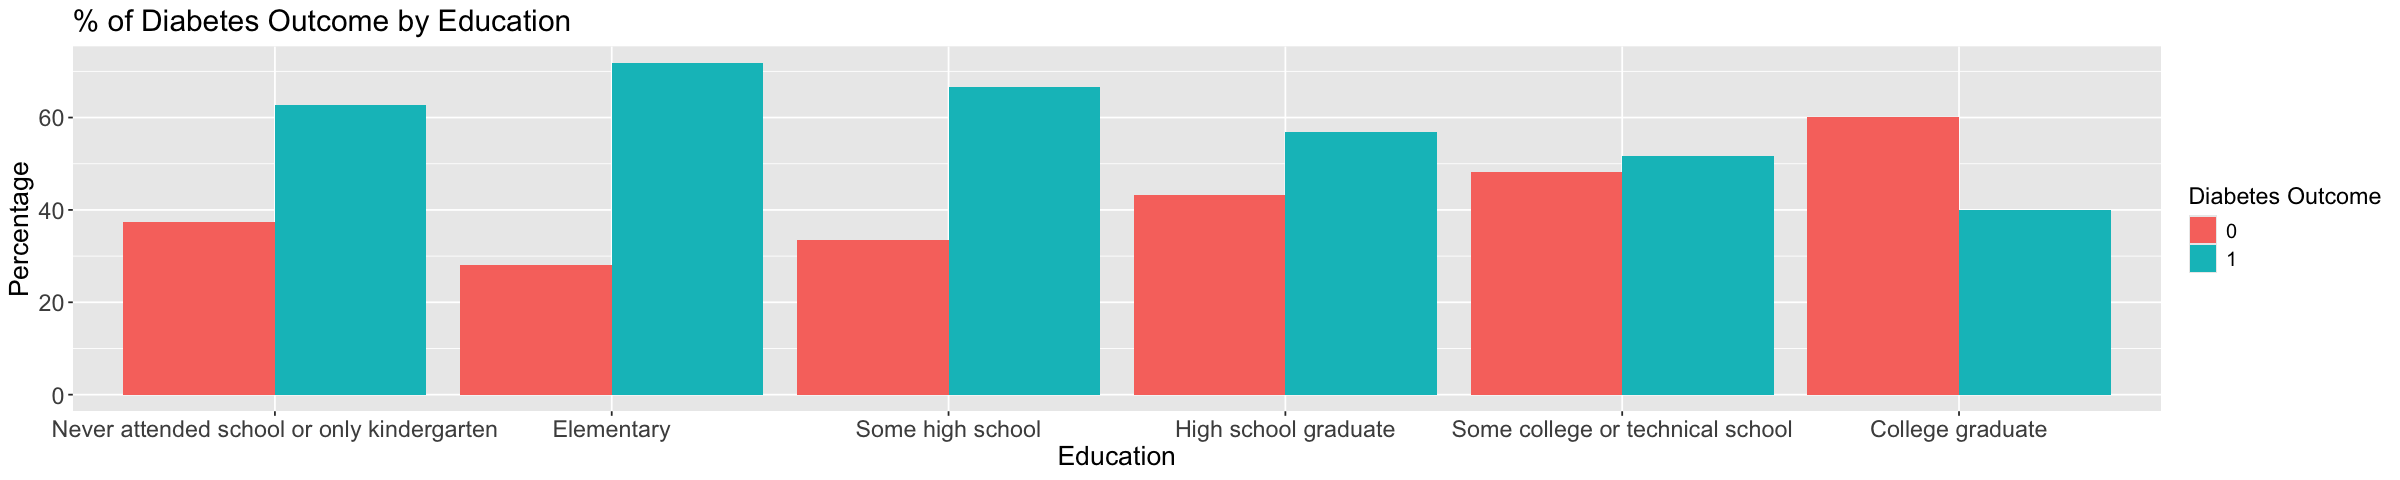

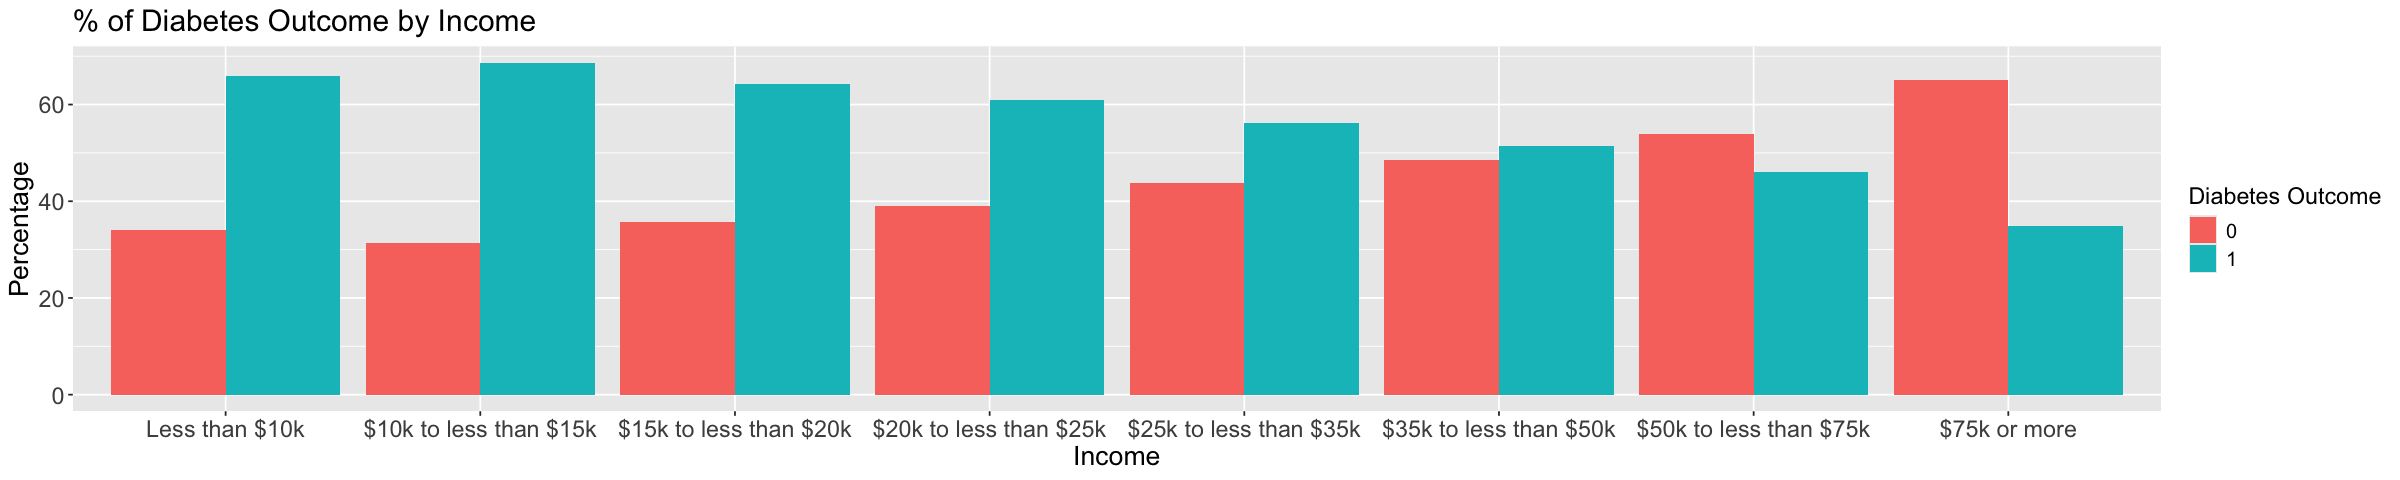

In [25]:
options(repr.plot.width = 20, repr.plot.height = 4)
print(plot_ordinal(df0, "Age", "Age"))
print(plot_ordinal(df0, "Education", "Education"))
print(plot_ordinal(df0, "Income", "Income"))
options(repr.plot.width = NULL, repr.plot.height = NULL)

#### Percentage analysis: categorical variables

In [26]:
df_n <- NULL
for (var in var_discrete) {
  breakdown <- as.data.frame(table(df0[[var]], df0[[target]])) %>%
    pivot_wider(names_from = "Var2", values_from = "Freq")
  df_n <- rbind(df_n, cbind(var, breakdown))
}
df_n <- as.data.frame(df_n) %>%
  rename("level" = "Var1",
         "n_0" = "0",
         "n_1" = "1") %>%
  mutate(percent_0 = n_0 / (n_0 + n_1)*100) %>%
  mutate(percent_1 = n_1 / (n_0 + n_1)*100)
rm(var, breakdown)
df_n

var,level,n_0,n_1,percent_0,percent_1
<chr>,<fct>,<int>,<int>,<dbl>,<dbl>
HighBP,0,22118,8742,71.67207,28.327933
HighBP,1,13228,26604,33.20948,66.790520
HighChol,0,21869,11660,65.22413,34.775866
HighChol,1,13477,23686,36.26456,63.735436
CholCheck,0,1508,241,86.22070,13.779302
CholCheck,1,33838,35105,49.08112,50.918875
Smoker,0,20065,17029,54.09231,45.907694
Smoker,1,15281,18317,45.48187,54.518126
Stroke,0,34219,32078,51.61470,48.385296


#### Summary statistics: continuous variables

In [27]:
df_statistics <- NULL
for (var in var_continuous) {
  statistics <- c(mean(df0[[var]]), sd(df0[[var]]),
                  min(df0[[var]]), quantile(df0[[var]], 0.25),
                  quantile(df0[[var]], 0.5),
                  quantile(df0[[var]], 0.75),
                  max(df0[[var]]))
  df_statistics <- rbind(df_statistics, c(var, statistics))
}
df_statistics <- as.data.frame(df_statistics) %>%
  rename("var" = "V1", "mean" = "V2", "sd" = "V3",
         "min" = "V4", "0.25p" = "25%",
         "0.5p" = "50%", "0.75p" = "75%", "max" = "V8")
rownames(df_statistics) <- NULL
rm(var, statistics)
df_statistics

var,mean,sd,min,0.25p,0.5p,0.75p,max
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BMI,29.8569852317091,7.1139538515769,12,25,29,33,98
MentHlth,3.75203700560238,8.15562655360549,0,0,0,2,30
PhysHlth,5.81041702031227,10.0622605311617,0,0,0,6,30


#### Conclusion
* The dataset is balanced
* The following groups of respondents show a significantly increased risk of having pre-diabetes or diabetes:
    * High blood pressure: 66.8% compared to 28.3% for those with normal blood pressure
    * High cholesterol levels: 63.7% compared to 34.8% for those without high cholesterol
    * Cholesterol check within the past 5 years: 50.9% compared to 13.8% for those who did not receive a cholesterol check
    * History of stroke: 74.4% compared to 48.4% for those without a history of stroke
    * Coronary heart disease (CHD) or myocardial infarction (MI): 75.4% compared to 45.6% for those without CHD or MI
    * No physical activity in the past 30 days: 62.2% compared to 44.8% for those who engaged in physical activity
    * Serious difficulty walking or climbing stairs: 73.4% compared to 42.1% for those without mobility issues
   
* The following groups do not exhibit a significantly higher risk of having pre-diabetes or diabetes
    * Smoking history: 54.5% for those who smoked at least 100 cigarettes in their lifetime compared to 45.9% for non-smokers
    * Infrequent fruit consumption: 53.4% for those not consuming fruit daily compared to 47.8% for those who do
    * Infrequent vegetable consumption: 57.7% for those not consuming vegetables daily compared to 47.9% for those who do
    * Health care coverage: 50.3% for those with health care coverage compared to 44.7% for those without
    * Unable to see a doctor due to cost in the past 12 months: 56.4% for those unable to see a doctor compared to 49.3% for those who could.
    * Sex: 52.4% for males compared to 50.0% for females
* Heavy drinkers (adult men having >14 drinks per week, adult women having >7 drinks per week) are less likely to develop pre-diabetes or diabetes (27.5% vs 51.0%). This trend warrants further investigation.
* Individuals are at greater risk of having pre-diabetes or diabetes under the following conditions:
    * They perceive their general health as poor
    * They are of older age
    * They have lower levels of education
    * They have lower income levels
* The previous 4 points only show a correlation, they do not necessarily prove causation
* The median BMI is 29, which falls in the overweight category. In addition, the data is right-skewed, so logarithim transformation may be required. There are some extreme values or outliers, so clipping may be required when fitting regression model.
* The median perceived number of bad physical and mental health days is 0, indicating that most respondents do not frequently perceive their physical or mental health as poor.

### Hypothesis testing

In [28]:
bins <- c(-1, 0, 7, 14, 21, 28, 30)
labels <- c('0', '1-7', '8-14', '15-21', '22-28', '29-30')
df0$PhysHlth_group <- cut(df0[["PhysHlth"]], breaks = bins, labels = labels, right = TRUE)
df0$MentHlth_group <- cut(df0[["MentHlth"]], breaks = bins, labels = labels, right = TRUE)

In [29]:
target <- "Diabetes_binary"
var_continuous <- "BMI"
var_discrete <- setdiff(colnames(df0), c(var_continuous, target, "MentHlth", "PhysHlth"))

In [30]:
print(paste("Continuous variables:", paste(var_continuous, collapse = ", ")))
print(paste("Categorical variables:", paste(var_discrete, collapse = ", ")))

[1] "Continuous variables: BMI"
[1] "Categorical variables: HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, DiffWalk, Sex, Age, Education, Income, PhysHlth_group, MentHlth_group"


#### Chi square test: categorical variables

In [31]:
p_value <- c()
warn <- c()
for (var in var_discrete) {
  test <- quite_chisquare(df0, var, target)
  p_value <- c(p_value, test[["result"]])
  warn <- c(warn, !is_empty(test[["warnings"]]))
}
df_chisqaure <- data.frame(var = var_discrete, test = "chi_square",
                           p_value = p_value, warn = warn)

#### T-test: continuous variables

In [32]:
p_value <- c()
for (var in var_continuous) {
  test <- quite_t(df0, var, target)
  p_value <- c(p_value, test[["result"]][["p.value"]])
}
df_t <- data.frame(var = var_continuous, test = "t",
                   p_value = p_value, warn = NA)

In [33]:
df_hypothesis_test <- rbind(df_chisqaure, df_t) %>%
  arrange(match(var, colnames(df0))) %>%
  mutate(significant = (p_value < 0.05))
rm(p_value, warn, var, test, df_chisqaure, df_t)
df_hypothesis_test

var,test,p_value,warn,significant
<chr>,<chr>,<dbl>,<lgl>,<lgl>
HighBP,chi_square,0.000000e+00,FALSE,TRUE
HighChol,chi_square,0.000000e+00,FALSE,TRUE
CholCheck,chi_square,1.131744e-206,FALSE,TRUE
BMI,t,0.000000e+00,NA,TRUE
Smoker,chi_square,1.027623e-115,FALSE,TRUE
Stroke,chi_square,7.675953e-244,FALSE,TRUE
HeartDiseaseorAttack,chi_square,0.000000e+00,FALSE,TRUE
PhysActivity,chi_square,0.000000e+00,FALSE,TRUE
Fruits,chi_square,7.126725e-47,FALSE,TRUE


#### Conclusion

* The relationship between target and features are investigated. 
* Chi-sqaure test was performed for discrete variables including `HighBP`, `HighChol`, `CholCheck`, `Smoker`, `Stroke`, `HeartDiseaseorAttack`, `PhysActivity`, `Fruits`, `Veggies`, `HvyAlcoholConsump`, `AnyHealthcare`, `NoDocbcCost`, `GenHlth`, `DiffWalk`, `Sex`, `Age`, `Education`, `Income`, `PhysHlth_group`, `MentHlth_group`. All variables showed a statistically significant association with the target (p < 0.001). 
* A t-test was performed for the continuous variable `BMI`. A statistically significant result (p < 0.001) is obtained. 

### Data preprocessing

#### Feature engineering

Variables can be divided into groups 
1. Health: `HighBP`, `HighChol`, `BMI`, `Stroke`, `HeartDiseaseorAttack`, `DiffWalk`
2. Perceived health: `GenHlth`, `MentHlth`, `PhysHlth`
3. Lifestyle: `CholCheck`, `Smoker`, `PhysActivity`, `Fruits`, `Veggies`, `HvyAlcoholConsump`
4. Financial difficulty: `AnyHealthcare`, `NoDocbcCost`
5. Demographic: `Sex`, `Age`, `Education`, `Income`

To prevent from overfit and facilitate the interpretation, the following actions will be done
1. Creat a new variable `cvd` representing the cardiovascular diseases including high blood pressure `HighBP`, high cholesterol `HighChol`, stroke `Stroke`, coronary heart disease (CHD), and myocardial infarction (MI) `HeartDiseaseorAttack`. 
2. Perform logarithmic transformation and truncation on `BMI`
3. To avoid recall bias, all of the perceived health i.e. `GenHlth`, `MentHlth`, `PhysHlth` are not selected. 
4. Create a new variable `healthy_diet` which combines `Fruits` and `Veggies` and represents whether the person has a healthy diet
5. Not select any variables related to financial difficulty `AnyHealthcare`, `NoDocbcCost` because `Income` already reflect the difficulty
6. Keep all demographic variables: `Sex`, `Age`, `Education`, `Income`

In [39]:
print(names(df0))

 [1] "Diabetes_binary"      "HighBP"               "HighChol"            
 [4] "CholCheck"            "BMI"                  "Smoker"              
 [7] "Stroke"               "HeartDiseaseorAttack" "PhysActivity"        
[10] "Fruits"               "Veggies"              "HvyAlcoholConsump"   
[13] "AnyHealthcare"        "NoDocbcCost"          "GenHlth"             
[16] "MentHlth"             "PhysHlth"             "DiffWalk"            
[19] "Sex"                  "Age"                  "Education"           
[22] "Income"               "PhysHlth_group"       "MentHlth_group"      


In [159]:
condition1 <- df0$HighBP == 0 & df0$HighChol == 0 &
  df0$HeartDiseaseorAttack == 0 & df0$Stroke == 0
condition2 <- df0$Fruits == 0 & df0$Veggies == 0
df1 <- df0 %>%
  mutate(cvd = factor(ifelse(condition1, 0, 1), levels = c(0, 1), labels = c("No", "Yes"))) %>%
  mutate(healthy_diet = factor(ifelse(condition2, 0, 1), levels = c(0, 1), labels = c("No", "Yes"))) %>%
  filter(BMI < quantile(BMI, 0.99)) %>%
  mutate(BMI := log(BMI))
rm(condition1, condition2)

#### Data partition

In [160]:
set.seed(111)
index <- createDataPartition(df1[[target]], p = 0.8, list = FALSE, times = 1)
df_train <- df1[index, ]
df_test <- df1[-index, ]
cat("Number of rows in training set: ", nrow(df_train), "\n")
cat("Number of columns in training set: ", ncol(df_train), "\n")
cat("Number of rows in test set: ", nrow(df_test), "\n")
cat("Number of columns in test set: ", ncol(df_test))

Number of rows in training set:  55913 
Number of columns in training set:  26 
Number of rows in test set:  13978 
Number of columns in test set:  26

### Model building and selction

* Target: `Diabetes_binary`
* Included features: `cvd`, `BMI`, `DiffWalk`, `healthy_diet`, `CholCheck`, `Smoker`, `PhysActivity`, `HvyAlcoholConsump`, `Sex`, `Age`, `Education`, `Income`
* Ignored features: `HighBP`, `HighChol`, `Stroke`, `HeartDiseaseorAttack`, `GenHlth`, `MentHlth`, `PhysHlth`, `Fruits`, `Veggies`, `AnyHealthcare`, `NoDocbcCost`, `PhysHlth_group`, `MentHlth_group`
* Conduct backward selection to elminate uncessary features

In [161]:
columns <- colnames(df1)
columns <- setdiff(columns, c("HighBP", "HighChol", "Stroke", "HeartDiseaseorAttack", "GenHlth", "MentHlth", "PhysHlth", "Fruits", "Veggies", "AnyHealthcare", "NoDocbcCost", "PhysHlth_group", "MentHlth_group"))
df <- df_train[, columns]
features <- setdiff(colnames(df), target)
x <- paste(features, collapse = " + ")
formula <- as.formula(paste(target, "~", x))
model1 <- glm2(formula, family = binomial, data = df)
summary(model1)


Call:
glm2(formula = formula, family = binomial, data = df)

Coefficients:
                                            Estimate Std. Error z value
(Intercept)                               -13.357572   0.387943 -34.432
CholCheck1                                  1.375485   0.087458  15.727
BMI                                         2.923891   0.055389  52.789
Smoker1                                     0.056021   0.020558   2.725
PhysActivity1                              -0.164489   0.023011  -7.148
HvyAlcoholConsump1                         -0.745925   0.052703 -14.153
DiffWalk1                                   0.505268   0.025606  19.733
Sex1                                        0.314409   0.020636  15.236
Age25-29                                   -0.026861   0.179227  -0.150
Age30-34                                    0.376984   0.160860   2.344
Age35-39                                    0.733216   0.152445   4.810
Age40-44                                    0.965877   0.149

In [162]:
model1_final <- step(model1, direction = "backward")

Start:  AIC=60211.01
Diabetes_binary ~ CholCheck + BMI + Smoker + PhysActivity + HvyAlcoholConsump + 
    DiffWalk + Sex + Age + Education + Income + cvd + healthy_diet

                    Df Deviance   AIC
<none>                    60143 60211
- healthy_diet       1    60146 60212
- Smoker             1    60150 60216
- PhysActivity       1    60194 60260
- Education          5    60208 60266
- HvyAlcoholConsump  1    60353 60419
- Sex                1    60376 60442
- CholCheck          1    60441 60507
- DiffWalk           1    60538 60604
- Income             7    60687 60741
- Age               12    61913 61957
- cvd                1    62393 62459
- BMI                1    63167 63233


In [163]:
summary(model1_final)


Call:
glm2(formula = Diabetes_binary ~ CholCheck + BMI + Smoker + PhysActivity + 
    HvyAlcoholConsump + DiffWalk + Sex + Age + Education + Income + 
    cvd + healthy_diet, family = binomial, data = df)

Coefficients:
                                            Estimate Std. Error z value
(Intercept)                               -13.357572   0.387943 -34.432
CholCheck1                                  1.375485   0.087458  15.727
BMI                                         2.923891   0.055389  52.789
Smoker1                                     0.056021   0.020558   2.725
PhysActivity1                              -0.164489   0.023011  -7.148
HvyAlcoholConsump1                         -0.745925   0.052703 -14.153
DiffWalk1                                   0.505268   0.025606  19.733
Sex1                                        0.314409   0.020636  15.236
Age25-29                                   -0.026861   0.179227  -0.150
Age30-34                                    0.376984   0.16

### Model diagnostics

#### Goodness of fit

##### AUC

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.801"


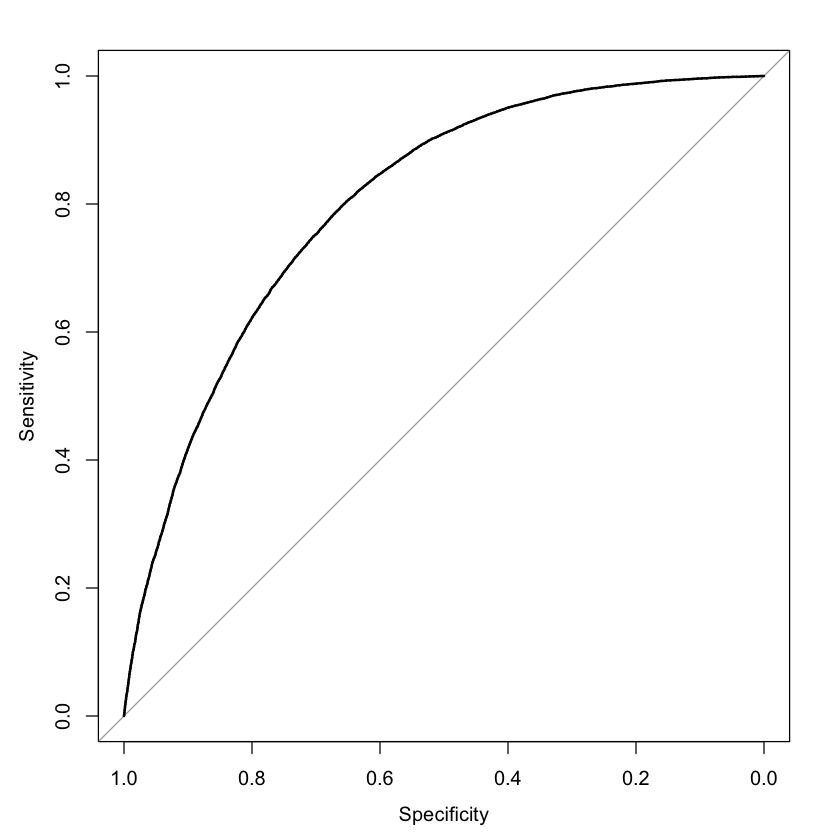

In [164]:
roc_curve <- roc(model1_final$y, fitted(model1_final)) 
par(bg = "white")
plot(roc_curve) 
print(paste("AUC:", round(auc(roc_curve), 3)))

##### Pseudo R-squared

In [165]:
descr::LogRegR2(model1_final)

Chi2                 17366.95 
Df                   33 
Sig.                 0 
Cox and Snell Index  0.2669979 
Nagelkerke Index     0.3560013 
McFadden's R2        0.2240609 

##### Deviance Ratio

In [166]:
ratio <- model1_final$deviance / model1_final$df.residual
# print(model2$deviance)
# print(model2$df.residual)
print(paste("Residual Deviance divided by DF:", round(ratio, 2)))

[1] "Residual Deviance divided by DF: 1.08"


- The ratio of 1.08 is slightly above 1, indicating mild overdispersion in your model

#### Multi-collinearity

In [167]:
car::vif(model1_final)

,GVIF,Df,GVIF^(1/(2*Df))
CholCheck,1.006546,1,1.003268
BMI,1.100999,1,1.049285
Smoker,1.069106,1,1.033976
PhysActivity,1.101632,1,1.049587
HvyAlcoholConsump,1.012155,1,1.006059
DiffWalk,1.172601,1,1.082867
Sex,1.075309,1,1.036971
Age,1.241983,12,1.009070
Education,1.347750,5,1.030293
Income,1.508918,7,1.029821


* As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity. In our example, there is no collinearity: all variables have a value of VIF well below 5.

#### Linear relationship
* Check the linear relationship between continuous predictor variables and the logit of the outcome

In [168]:
probabilities <- predict(model1_final, type = "response")
df_linear_relationship <- model1_final$data %>% 
    dplyr::select_if(is.numeric)
predictors <- colnames(df_linear_relationship)
df_linear_relationship <- df_linear_relationship %>%
  mutate(logit = log(probabilities/(1-probabilities))) %>%
  gather(key = "predictors", value = "predictor.value", -logit)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


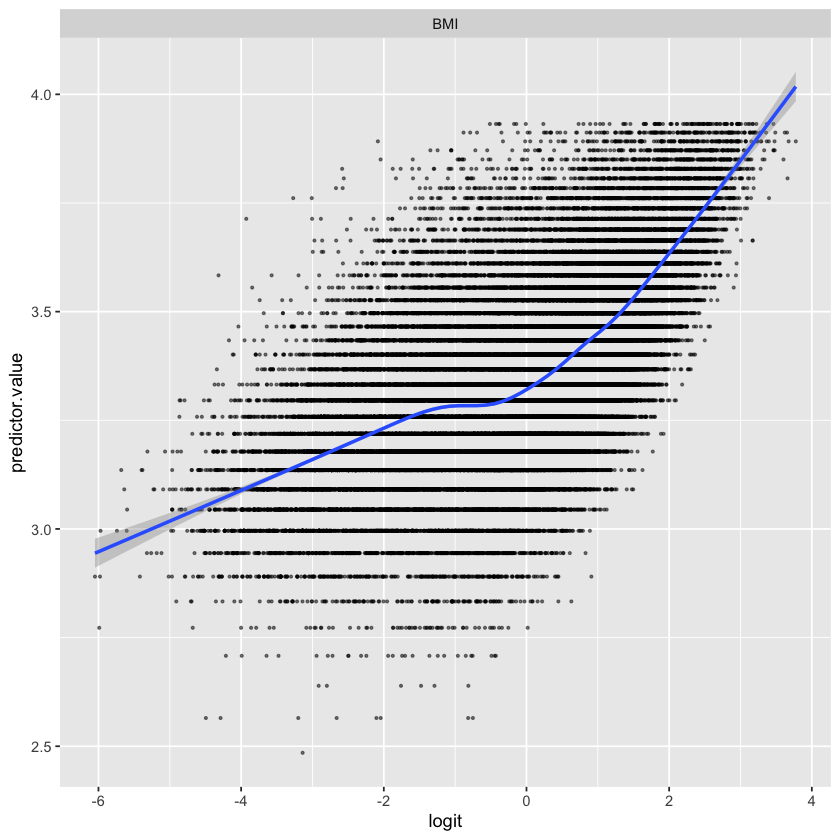

In [169]:
ggplot(df_linear_relationship, aes(logit, predictor.value))+
  geom_point(size = 0.5, alpha = 0.5) +
  geom_smooth() + 
  facet_wrap(~predictors, scales = "free_y")

* After logarithm transformation and clipping, a linear relationship were shown

#### Influential observations

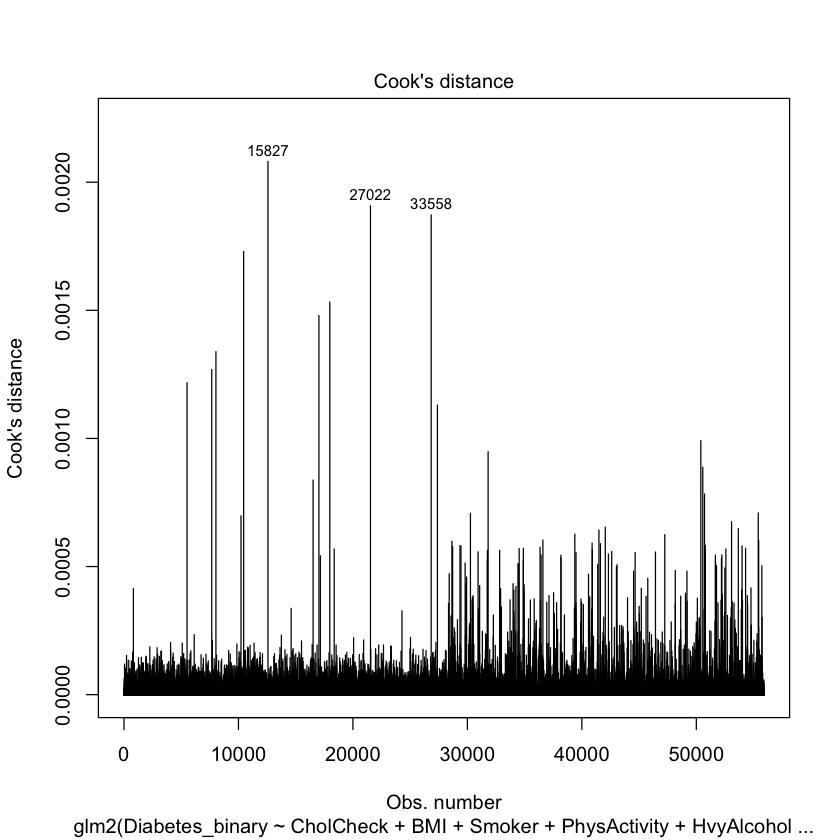

In [170]:
par(bg = "white")
plot(model1_final, which = 4, id.n = 3)

In [171]:
cooks_distances <- cooks.distance(model1_final)
influential_obs <- which(cooks_distances > 1)
print(influential_obs)

named integer(0)


- None of the observations are considered influential
- The model is stable with respect to the observations

### Model interpretation

In [175]:
summary(model1_final)


Call:
glm2(formula = Diabetes_binary ~ CholCheck + BMI + Smoker + PhysActivity + 
    HvyAlcoholConsump + DiffWalk + Sex + Age + Education + Income + 
    cvd + healthy_diet, family = binomial, data = df)

Coefficients:
                                            Estimate Std. Error z value
(Intercept)                               -13.357572   0.387943 -34.432
CholCheck1                                  1.375485   0.087458  15.727
BMI                                         2.923891   0.055389  52.789
Smoker1                                     0.056021   0.020558   2.725
PhysActivity1                              -0.164489   0.023011  -7.148
HvyAlcoholConsump1                         -0.745925   0.052703 -14.153
DiffWalk1                                   0.505268   0.025606  19.733
Sex1                                        0.314409   0.020636  15.236
Age25-29                                   -0.026861   0.179227  -0.150
Age30-34                                    0.376984   0.16

In [176]:
adjusted_odd_ratio <- exp(cbind(OR = coef(model1_final), confint(model1_final)))

Waiting for profiling to be done...



In [177]:
print(adjusted_odd_ratio)

                                                    OR        2.5 %
(Intercept)                               1.580812e-06 7.418308e-07
CholCheck1                                3.956997e+00 3.340993e+00
BMI                                       1.861356e+01 1.670224e+01
Smoker1                                   1.057620e+00 1.015844e+00
PhysActivity1                             8.483271e-01 8.109153e-01
HvyAlcoholConsump1                        4.742955e-01 4.275609e-01
DiffWalk1                                 1.657430e+00 1.576372e+00
Sex1                                      1.369449e+00 1.315190e+00
Age25-29                                  9.734970e-01 6.871025e-01
Age30-34                                  1.457882e+00 1.069779e+00
Age35-39                                  2.081766e+00 1.554719e+00
Age40-44                                  2.627091e+00 1.975976e+00
Age45-49                                  3.319406e+00 2.509354e+00
Age50-54                                  4.1931

* Individuals who had a cholesterol check were more likely to have diabetes (AOR = 3.96, 95% CI: 3.34–4.71, p < 0.001)
* The log-transformed BMI had an odds ratio of 18.61 (95% CI: 16.70–20.75, p < 0.001), indicating that a proportional increase in BMI significantly increases the odds of diabetes.
* Smoking was associated with a modest increase in the odds of diabetes (AOR = 1.06, 95% CI: 1.02–1.10, p = 0.006)
* Engaging in physical activity was protective against diabetes, with an AOR of 0.85 (95% CI: 0.81–0.89, p < 0.001).
* Heavy alcohol consumption was inversely associated with diabetes risk (AOR = 0.47, 95% CI: 0.43–0.53, p < 0.001).
* Individuals reporting difficulty walking had significantly higher odds of diabetes (AOR = 1.66, 95% CI: 1.58–1.74, p < 0.001)
* Males had increased odds of diabetes compared to females (AOR = 1.37, 95% CI: 1.32–1.43, p < 0.001)
* Cardiovascular disease (CVD) was strongly associated with diabetes risk (AOR = 3.32, 95% CI: 3.16–3.50, p < 0.001).
* The odds of diabetes increased significantly with age. For instance, individuals aged 55–59 years had 4.65 times higher odds (95% CI: 3.53–6.21, p < 0.001), and those aged 80 years or older had 7.02 times higher odds (95% CI: 5.32–9.42, p < 0.001) compared to the reference group (18–24 years)
* Higher income was inversely associated with diabetes risk. For example, individuals earning $75,000 or more had 55% lower odds of diabetes compared to those earning less than $10,000 (AOR = 0.45, 95% CI: 0.41–0.50, p < 0.001).

### Model evaluation

In [172]:
model_evaluation <- function(model, data, target_name) {
    predicted_prob <- predict(model, newdata = data, type = "response")
    predict <- (predicted_prob >= 0.5)
    confusion_matrix <- table(data[[target_name]], predict)
    print("Confusion matrix: ")
    print(confusion_matrix)
    accuracy_test <- (confusion_matrix[1,1] + confusion_matrix[2,2])/nrow(data)
    print(paste("Accuracy: ", round(accuracy_test,4)))
    roc_curve <- roc(data[[target_name]], predicted_prob)
    auc_value <- auc(roc_curve)
    print(paste("AUC: ", round(auc_value, 4)))
}

In [174]:
model_evaluation(model1_final, df_test, target)

[1] "Confusion matrix: "
   predict
    FALSE TRUE
  0  4814 2216
  1  1613 5335
[1] "Accuracy:  0.7261"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC:  0.8014"


* The model showed satisfying performance
* Accuracy: 0.73
* AUC: 0.80

## Discussion
The adjusted odds ratio (OR) of 0.47 (95% CI: 0.43–0.53) suggests that heavy drinking (HvyAlcoholConsump = 1) is associated with lower odds of diabetes, which is counterintuitive given existing literature linking heavy alcohol use to an increased risk of type 2 diabetes. Several methodological and data-related factors may explain this finding, each with potential solutions:
### Sampling Bias from Downsampling
- Problem: The [data provider downsampled](https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook) the [original Behavioural Risk Factor Surveillance System (BRFSS) data](https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system/data), randomly selecting 35,346 non-diabetes cases from 218,334 to create an artificial 50:50 split with 35,346 diabetes cases (source code from data provider). This distorts the natural diabetes prevalence (~14% in the original dataset) and may introduce bias, as highlighted by [IBM](https://www.ibm.com/think/topics/downsampling), potentially skewing the odds ratio for heavy alcohol consumption’s effect on diabetes.
- Solution: The preferred approach is to use the raw BRFSS data without downsampling to preserve the true prevalence. Alternatively, if using the provided dataset, apply sampling weights (e.g., 6.18 for non-diabetes, 1 for diabetes) to reflect the original population and ensure accurate statistical inference. In machine learning, techniques like downsampling, upsampling, bootstrapping, or SMOTE prioritise prediction over inference and are unsuitable for estimating unbiased odds ratios.
### Diabetes Type
- Problem: The dataset includes type 1, type 2, and potentially gestational diabetes, with no variables to distinguish diabetes type or pregnancy status. Some researchers (e.g., [Z. Xie, O. Nikolayeva, J. Luo, and D. Li (2019)](https://www.cdc.gov/pcd/issues/2019/19_0109.htm#methods)) limit analyses to respondents over 30, not pregnant, and answering “yes” to “Have you ever been told you have diabetes?” to focus on type 2 diabetes, excluding type 1 and gestational cases. Without these distinctions, the odds ratio estimation may be biased.
- Solution: Using the raw BRFSS data, which includes pregnancy status, would enable exclusion of pregnant respondents and improve differentiation of diabetes types.
### Reverse Causation and Cross-Sectional Design
- Problem: The OR of 0.47 might reflect reverse causation—e.g., people with diabetes reducing alcohol intake post-diagnosis—rather than a protective effect of heavy drinking. Most literature associates heavy alcohol use with increased type 2 diabetes risk (e.g., via insulin resistance), making this finding unexpected. However, as a cross-sectional study, this dataset cannot establish temporality, a key limitation for causal inference.
- Solution: Longitudinal studies tracking alcohol consumption and diabetes onset over time are ideal for addressing reverse causation. With longitudinal data, propensity score matching (PSM) could estimate the causal effect of heavy drinking by balancing confounders (e.g., age, sex, BMI) between heavy drinkers and non-drinkers. However, PSM assumes all relevant confounders are measured and included in the propensity score calculation, and it reduces sample size by excluding unmatched cases, a notable drawback.